In [1]:
%pylab inline
import pandas
import sqlite3
import pymc3
import seaborn as sns
from sklearn import *
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


/home/riri/.virtualenvs/mxnet-3/lib/python3.4/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/home/riri/.virtualenvs/mxnet-3/lib/python3.4/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [2]:
con = sqlite3.connect('/tmp/data.sqlite3')

In [4]:
pandas.read_sql('SELECT rand, count(*) FROM data group by 1', con=con)

,rand,count(*)
0,0,811564
1,1,812154
2,2,809576
3,3,810845
4,4,810395
5,5,812462
6,6,811479
7,7,810026
8,8,813153
9,9,811463


In [5]:
pandas.read_sql('SELECT week_num, count(*) FROM data group by 1', con=con)

,week_num,count(*)
0,3,11165207
1,4,11009593
2,5,10615397
3,6,10191837
4,7,10382849
5,8,10406868
6,9,10408713
7,10,3538385
8,11,3460866


In [3]:
sample = pandas.read_sql('SELECT * FROM data where sales_depo < 1200 and adjusted_demand is not null', con=con)

In [4]:
print(sample.shape)
sample.dtypes

(9344979, 13)


id                         object
week_num                    int64
sales_depo                  int64
sales_channel               int64
route_id                    int64
client_id                   int64
product_id                  int64
week_sales                float64
week_returns              float64
next_week_returns           int64
next_week_returns_peso    float64
adjusted_demand             int64
rand                        int64
dtype: object

In [8]:
def aggregate_field(sample, field_name):
    return pandas.merge(
        sample, 
        sample.groupby(field_name).adjusted_demand.median().rename(field_name + '_median').to_frame(),
        left_on=field_name, right_index=True).drop(field_name, axis=1)

x = sample
x = aggregate_field(x, 'week_num')
x = aggregate_field(x, 'sales_depo')
x = aggregate_field(x, 'sales_channel')
x = aggregate_field(x, 'route_id')
x = aggregate_field(x, 'client_id')
x = aggregate_field(x, 'product_id')
x = x.drop(['id', 'week_sales', 'week_returns', 'next_week_returns', 'next_week_returns_peso', 'rand'], axis=1)

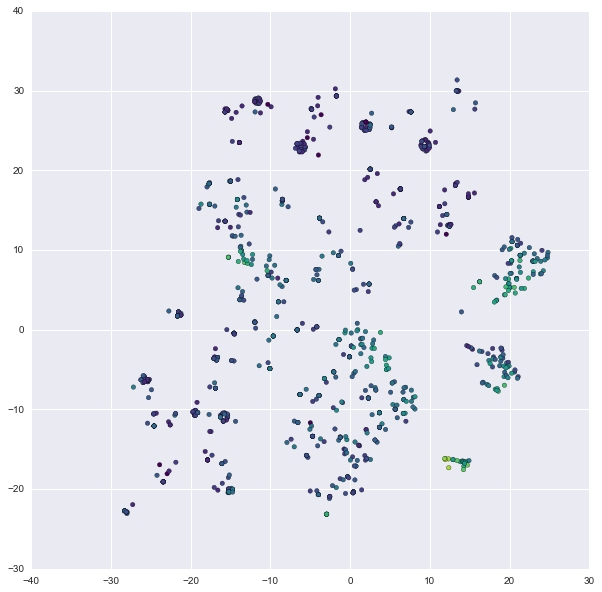

In [9]:
manif = manifold.TSNE()
samp = x.sample(1000)
loc = manif.fit_transform(samp.drop('adjusted_demand', axis=1))
figure(figsize=(10, 10))
scatter(*loc.T, cmap='viridis', c=np.log(samp.adjusted_demand + 1))